In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
nlp = spacy.load('en')

import tweepy
import os
import csv
import re
import time
import pickle
import preprocessor as p
import itertools
from collections import Counter
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
keys = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/twitterkeys.csv')

In [3]:
ckey = keys.consumer_key[0]
csecret = keys.consumer_secret[0]
atoken = keys.access_token[0]
asecret = keys.access_secret[0]

auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token(atoken, asecret)
api = tweepy.API(auth)

In [4]:
def get_tweets(user):    
    tweetlist = []
    tweets = api.user_timeline(screen_name=user, count=200, include_rts=False)
    tweetlist.extend(tweets)
    lastweet = tweetlist[-1].id-1
    
    while len(tweets) > 0:
        tweets = api.user_timeline(screen_name=user, count=200, include_rts=False, max_id=lastweet)
        tweetlist.extend(tweets)
        lastweet = tweetlist[-1].id-1
        print(len(tweetlist), ' downloaded so far')
    
    outtweets = [[tweet.text.encode('utf-8')] for tweet in tweetlist]
    print(outtweets)
    with open (' {}.csv'.format(user), 'w') as f:
        writer = csv.writer(f)
        writer.writerows('t')
        writer.writerows(outtweets)
#Code sourced from https://gist.github.com/yanofsky/5436496

get_tweets('justinbieber')
get_tweets('jtimberlake')
get_tweets('zaynmalik')
get_tweets('chrisbrown')
get_tweets('brunomars')
get_tweets('selenagomez')
get_tweets('ddlovato')
get_tweets('aliciakeys')
get_tweets('ladygaga')
get_tweets('katyperry')


In [5]:
jb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/justinbieber.csv')
jt = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/jtimberlake.csv')
zm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/zaynmalik.csv')
cb = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/chrisbrown.csv')
bm = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/brunomars.csv')
sg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/selenagomez.csv')
dl = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ddlovato.csv')
ak = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/aliciakeys.csv')
lg = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/ladygaga.csv')
kp = pd.read_csv('C:/Users/JChaotogo/Documents/DataSets/tweets/katyperry.csv')

In [6]:
jb['artist'] = 'justinbieber'
jt['artist'] = 'justintimberlake'
zm['artist'] = 'zaynmalik'
cb['artist'] = 'chrisbrown'
bm['artist'] = 'brunomars'
sg['artist'] = 'selenagomez'
dl['artist'] = 'demilovato'
ak['artist'] = 'aliciakeys'
lg['artist'] = 'ladygaga'
kp['artist'] = 'katyperry'

In [7]:
zm.head()

,t,artist
0,b'Thank you @Spotify \xf0\x9f\x99\x8c\xf0\x9f\x8f\xbd \nhttps://t.co/DUMWKSiGYN https://t.co/RlQhR0gRLR',zaynmalik
1,b'#ICARUSFALLS out now worldwide \nhttps://t.co/gjo7ka4PyC \xf0\x9f\x91\x90\xf0\x9f\x8f\xbd https://t.co/cf1Uqe7N9y',zaynmalik
2,b'Last capsule before the album\xe2\x80\x99s out round the world https://t.co/a3GUUHAI0g\n#ICARUSFALLS https://t.co/Je5t3aI0Of',zaynmalik
3,b'@BrendaSolangeee thank you for the letter and for all your support. Big love \xe2\x99\xa5\xef\xb8\x8fx z',zaynmalik
4,b'Thank you to everyone supporting the music. Big love to everyone that came out tonight! #IcarusFallsParty',zaynmalik


In [8]:
#Combine the tweets of all artists into one dataframe
alltweets = pd.concat([jb,jt,zm,cb,bm,sg,dl,ak,lg,kp])

In [9]:
#Preprocessor is a python package that preprocesses tweets by removing abundant useless information such as
#emojis urls and symbols.
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION)
alltweets['cleaned'] = alltweets['t'].apply(lambda x: p.clean(x))
alltweets.cleaned = alltweets.cleaned.str.lower()
alltweets.cleaned = alltweets.cleaned.str.strip()
alltweets.cleaned = alltweets.cleaned.str.replace("b'", '')
alltweets.cleaned = alltweets.cleaned.str.replace('b"', '')

In [10]:
#Preprocessor doesnt seem to remove all emojis, and our data is still rather dirty.
def removeemoji(text):
    clean = re.sub(r'\\', '', text)
    clean = re.sub(r'(x..){3,}','',clean)
    return clean

def GetSpecialChar(x):
    special_characters = []
    for char in x:
        if char.isalpha() == False:
            special_characters.append(char)
    return special_characters

special_characters = alltweets.cleaned.apply(lambda x: GetSpecialChar(x))
special_characters = list(set(itertools.chain.from_iterable(special_characters)))
special_characters.remove(' ')

alltweets.cleaned = alltweets.cleaned.apply(lambda x: removeemoji(x))
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace("can't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("won't", '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\nhttps:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https:', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https://', '')
alltweets.cleaned = alltweets.cleaned.str.replace('\\n', '')
alltweets.cleaned = alltweets.cleaned.str.replace('https', '')
alltweets.cleaned = alltweets.cleaned.str.replace("n't", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'t", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'s", '')
alltweets.cleaned = alltweets.cleaned.str.replace("'re", '')
alltweets.cleaned = alltweets.cleaned.apply(lambda x: re.sub(r'(.)\1{3,}.*$', '', x)) #Removes words with 3+ repeating letters

for char in (special_characters):
    alltweets.cleaned = alltweets.cleaned.str.replace(char, '')
alltweets.cleaned = alltweets.cleaned.str.strip()

alltweets

,t,artist,cleaned
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song
6,b'https://t.co/Ehx7cDu0Nw',justinbieber,
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day


In [11]:
from nltk.stem.wordnet import WordNetLemmatizer
lem = WordNetLemmatizer()
alltweets['tokenized'] = alltweets.cleaned.apply(lambda x: word_tokenize(x))
def removestop(x):
    newlist = []
    for w in x:
        if w not in stopwords and len(w)>1:
            w = lem.lemmatize(w)
            newlist.append(w)
    return newlist

alltweets['tokenized'] = alltweets.tokenized.apply(lambda x: removestop(x))
alltweets

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,"[love, aaron, got, support]"
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,"[aaron, carter, album, little, bumped, song, aaron, party, like, need, hype, man, got]"
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,"[xkarla, donate, portion, proceeds, humane, society, help, animal, hurt, displaced, fire]"
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,"[year, ago, today, released, purpose, thank]"
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,"[thank, next, bop, favorite, song, least, song, smash, fire]"
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song,"[congrats, new, song]"
6,b'https://t.co/Ehx7cDu0Nw',justinbieber,,[]
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible,"[listened, album, time, row, incredible]"
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh,"[praying, pittsburgh]"
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day,"[wishing, everyone, amazing, day]"


In [12]:
alltweets.tokenized = alltweets.tokenized.apply(lambda x: ' '.join(x))
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [13]:
#Remove empty tweets
finaltweets = alltweets[(alltweets.tokenized !='')&(alltweets.tokenized!=' ')]
finaltweets

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire
5,b'@carlyraejepsen Congrats on the new song!',justinbieber,congrats on the new song,congrats new song
7,b'@torikelly I have listened to this album 10 times in a row. Incredible',justinbieber,i have listened to this album times in a row incredible,listened album time row incredible
8,b'Praying for Pittsburgh',justinbieber,praying for pittsburgh,praying pittsburgh
9,b'Wishing everyone an amazing day',justinbieber,wishing everyone an amazing day,wishing everyone amazing day
10,b'Wow 3 years. Thanks https://t.co/1ou2v3MbCA',justinbieber,wow years thanks,wow year thanks


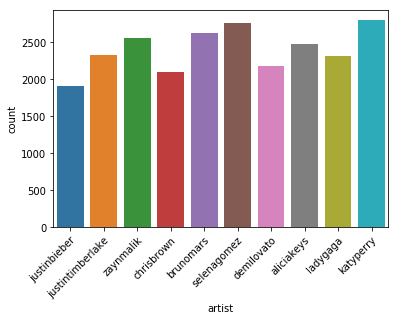

Tweets per Artist 
 katyperry           2797
selenagomez         2753
brunomars           2617
zaynmalik           2555
aliciakeys          2480
justintimberlake    2332
ladygaga            2316
demilovato          2174
chrisbrown          2096
justinbieber        1901
Name: artist, dtype: int64


In [14]:
sns.countplot(x=finaltweets.artist, data=finaltweets)
plt.xticks(rotation=45, rotation_mode='anchor', ha='right')
plt.show()
print('Tweets per Artist','\n',finaltweets.artist.value_counts())

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


In [16]:
X = finaltweets['tokenized']
Y = finaltweets['artist']

In [17]:
vectorizer = CountVectorizer()
vectorizer.fit(X)
Xdtm = vectorizer.transform(X)
Xdtm

<24021x16387 sparse matrix of type '<class 'numpy.int64'>'
	with 131989 stored elements in Compressed Sparse Row format>

In [18]:
features = pd.DataFrame(Xdtm.toarray(), columns=vectorizer.get_feature_names())
features.shape

(24021, 16387)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(Xdtm, Y, test_size=.3, random_state=0)

In [20]:
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train, y_train)
print('Training ACC score:', lgr.score(X_train, y_train))
print(' Testing ACC score:', lgr.score(X_test, y_test))
predy = lgr.predict(X_test)
print('\nCross-Tab\n',confusion_matrix(y_test, predy))
print('\nClassification Report\n', classification_report(y_test, predy))

Training ACC score: 0.8576781253717141
 Testing ACC score: 0.5572360205355904

Cross-Tab
 [[452  22   6  27  18  22  72  30  41  29]
 [ 18 400  12  27  35  22  91  20  65  67]
 [ 16  36 467  11  27   9  48   6  22  18]
 [ 36  55  11 287  19  23  75  20  63  52]
 [ 11  48  13  13 347  15  39  10  41  59]
 [ 27  58   8  19  25 354  71  24  57  54]
 [ 41  74  16  43  22  22 474  37  45  64]
 [ 40  53   8  27  24   7  83 366  56  33]
 [ 26  83  12  32  40  19  83  41 424  71]
 [ 20  72  13  31  34  26  66   8  56 445]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.66      0.63      0.64       719
       brunomars       0.44      0.53      0.48       757
      chrisbrown       0.83      0.71      0.76       660
      demilovato       0.56      0.45      0.50       641
    justinbieber       0.59      0.58      0.58       596
justintimberlake       0.68      0.51      0.58       697
       katyperry       0.43      0.57      0.49 

In [21]:
#Gets the punctuation count to use as a feature.
def periodcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

def questioncount(x):
    n = 0
    for char in x:
        if char == '?':
            n+=1
    return n

def exclaimcount(x):
    n = 0
    for char in x:
        if char == '.':
            n+=1
    return n

In [22]:
#Create some new features to try to improve predictions
#Punctuation count
#Length of tweet
finaltweets2 = pd.DataFrame() #make copy of tweets for testing
finaltweets2['p_1'] = finaltweets.t.apply(lambda x: periodcount(x))
finaltweets2['q_1'] = finaltweets.t.apply(lambda x: questioncount(x))
finaltweets2['e_1'] = finaltweets.t.apply(lambda x: exclaimcount(x))
#length of raw tweet
finaltweets2['c_1'] = finaltweets.t.apply(lambda x: len(x))
#Length of tweet w/ stopwords and special characters removed
finaltweets2['c_2'] = finaltweets.tokenized.apply(lambda x: len(x))
finaltweets2.head()

,p_1,q_1,e_1,c_1,c_2
0,1,0,1,47,22
1,4,0,4,146,72
2,1,0,1,149,77
3,1,0,1,49,37
4,3,0,3,76,50


In [23]:
finaltweets2.shape

(24021, 5)

In [24]:
#Concat original X with new features
X2 = pd.DataFrame.merge(features, finaltweets2, how='outer', on=features.index)

In [25]:
X2.drop(columns='key_0', inplace=True)
X2.head()

,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zuck,zuckerberg,zumyah,zurich,zuzu,p_1,q_1,e_1,c_1,c_2
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,47,22
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,4,0,4,146,72
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,149,77
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,49,37
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,3,76,50


In [26]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [27]:
lgr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nCross-Tab\n',confusion_matrix(y_test2, predy2))
print('\nClassification Report\n', classification_report(y_test2, predy2))

Training ACC score: 0.29493279410015466
 Testing ACC score: 0.2850006937699459

Cross-Tab
 [[299  28  33   0  23  24 119 139  32  22]
 [ 39 210  25   0  61  27  78  69  40 208]
 [128  81 176   0  19  10  54 104  36  52]
 [142  46  20   4  38  23 115 119  35  99]
 [ 52 155  36   0  89   6  35  24  63 136]
 [103  94  42   0 111 110  72  86  50  29]
 [134  72  25   0  27  16 254 119  31 160]
 [ 98  71  16   0  15  14  82 300  47  54]
 [ 73 130  67   0  91  14  75 133 157  91]
 [ 41  50  18   0  63   9  62  45  28 455]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.27      0.42      0.33       719
       brunomars       0.22      0.28      0.25       757
      chrisbrown       0.38      0.27      0.31       660
      demilovato       1.00      0.01      0.01       641
    justinbieber       0.17      0.15      0.16       596
justintimberlake       0.43      0.16      0.23       697
       katyperry       0.27      0.30      0.28

In [28]:
#We now have continuous features that need to be standardized
scaler = StandardScaler()
scaled = scaler.fit_transform(finaltweets2)
scaled = pd.DataFrame(scaled, columns = ['p_1', 'q_1', 'e_1', 'c_1', 'c_2'])
X2 = features.merge(scaled, left_index=True, right_index=True, how='left')
X2.head()

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,aa,aaah,aaaw,aadvantage,aah,aahoogaaa,aampe,aampr,aap,aaron,...,zuck,zuckerberg,zumyah,zurich,zuzu,p_1,q_1,e_1,c_1,c_2
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,-0.330187,-0.251006,-0.330187,-0.967206,-0.604652
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,1.655318,-0.251006,1.655318,0.951578,1.471080
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.330187,-0.251006,-0.330187,1.009723,1.678653
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-0.330187,-0.251006,-0.330187,-0.928443,0.018067
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.993483,-0.251006,0.993483,-0.405138,0.557758


In [29]:
X2 = scipy.sparse.csc_matrix(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y, test_size=.3, random_state=0)

In [30]:
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train2, y_train2)
print('Training ACC score:', lgr.score(X_train2, y_train2))
print(' Testing ACC score:', lgr.score(X_test2, y_test2))
predy2 = lgr.predict(X_test2)
print('\nCross-Tab\n',confusion_matrix(y_test2, predy2))
print('\nClassification Report\n', classification_report(y_test2, predy2))

Training ACC score: 0.8572023313905079
 Testing ACC score: 0.5888719300679894

Cross-Tab
 [[491  21   6  25  11  32  52  36  37   8]
 [ 12 411  11  18  52  31  52  14  61  95]
 [ 11  37 468  14  27   8  41   9  21  24]
 [ 36  51  10 284  11  33  75  29  54  58]
 [  7  55  10   6 371  13  28   8  31  67]
 [ 28  42   3  21  22 414  51  30  66  20]
 [ 55  65  13  29  21  26 477  38  47  67]
 [ 43  51   9  30  17  18  75 383  42  29]
 [ 21  77  17  36  50  35  59  41 440  55]
 [ 14  71   6  20  38  17  42   9  49 505]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.68      0.68      0.68       719
       brunomars       0.47      0.54      0.50       757
      chrisbrown       0.85      0.71      0.77       660
      demilovato       0.59      0.44      0.51       641
    justinbieber       0.60      0.62      0.61       596
justintimberlake       0.66      0.59      0.63       697
       katyperry       0.50      0.57      0.53 

In [31]:
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax', num_class=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train2, y_train2)
print(xgb.score(X_train2, y_train2))
print(xgb.score(X_test2, y_test2))
predxgb2 = xgb.predict(X_test2)
print('Cross-Tab\n\n',confusion_matrix(predxgb2, y_test2))
print('\nClassification Report\n\n', classification_report(y_test2, predxgb2))
print(time.time()-start)

0.8335315808255026
0.5831830165117247
Cross-Tab

 [[494  17  15  42   7  35  63  49  30   8]
 [ 19 398  46  41  41  34  55  37  69  61]
 [  4  12 450  10  11   9   7   6  16  14]
 [ 21  20  15 275  10  14  30  35  37  17]
 [ 11  34  19  14 369  16  21  19  40  30]
 [ 30  39  12  29  11 425  27  22  39  22]
 [ 61  67  46  74  36  53 462  69  71  39]
 [ 42  17  11  38   9  26  49 382  46  12]
 [ 29  63  28  60  46  60  47  47 435  55]
 [  8  90  18  58  56  25  77  31  48 513]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.65      0.69      0.67       719
       brunomars       0.50      0.53      0.51       757
      chrisbrown       0.83      0.68      0.75       660
      demilovato       0.58      0.43      0.49       641
    justinbieber       0.64      0.62      0.63       596
justintimberlake       0.65      0.61      0.63       697
       katyperry       0.47      0.55      0.51       838
        ladygaga       0.60  

In [32]:
from lightgbm import LGBMClassifier
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
                        learning_rate=0.3, max_depth=4, min_child_samples=20,
                        min_child_weight=.01, min_split_gain=0, n_estimators=700,
                        n_jobs=-1, num_leaves=100, objective='multiclass:softmax', num_class=10, random_state=0,
                        reg_alpha=0, reg_lambda=1, silent=True, subsample=1,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train2, y_train2)
print(lgb.score(X_train2, y_train2))
print(lgb.score(X_test2, y_test2))
predlgb2 = lgb.predict(X_test2)
print('Cross-Tab\n\n',confusion_matrix(predlgb2, y_test2))
print('\nClassification Report\n\n', classification_report(y_test2, predlgb2))
print(time.time()-start)

0.7190436540977757
0.5140835299014846
Cross-Tab

 [[448  22  15  46   8  42  72  55  40  15]
 [ 26 335  47  49  68  44  60  39  84  77]
 [  6  16 437  21  18  16  15  15  30  12]
 [ 20  21  17 219  16  19  28  37  30  12]
 [ 10  40  21  16 317  19  21  18  46  33]
 [ 38  43   9  34  17 357  39  21  53  17]
 [ 64  75  40  71  41  56 406  72  71  49]
 [ 53  21  14  48   7  33  48 333  55  13]
 [ 45  73  41  72  53  82  61  66 369  59]
 [  9 111  19  65  51  29  88  41  53 484]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.59      0.62      0.60       719
       brunomars       0.40      0.44      0.42       757
      chrisbrown       0.75      0.66      0.70       660
      demilovato       0.52      0.34      0.41       641
    justinbieber       0.59      0.53      0.56       596
justintimberlake       0.57      0.51      0.54       697
       katyperry       0.43      0.48      0.46       838
        ladygaga       0.53  

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid = TfidfVectorizer(max_df=.5, min_df=2, stop_words='english',
                     lowercase=True, use_idf=True, norm=u'l2',
                     smooth_idf=True)
tweetstfid = tfid.fit_transform(finaltweets.tokenized)

In [34]:
X3 = pd.DataFrame(tweetstfid.toarray())
X3 = X3.merge(scaled, left_index=True, right_index=True, how='left')


In [35]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import Normalizer

start = time.time()
pipe = Pipeline(steps=[('svd', TruncatedSVD(3000)), 
                       ('norm', Normalizer(copy=False))])
X3pipe = pipe.fit_transform(X3)
print(time.time()-start)

save_classifier = open('svd3000f.pickle','wb')
pickle.dump(X3pipe, save_classifier)
save_classifier.close()

In [36]:
svd3000load = open('svd3000f.pickle', 'rb')
X3pipe = pickle.load(svd3000load)
svd3000load.close()

In [37]:
#5000 features 97% explained variance
#3000 features 89% explained variance
pipe.get_params()['svd'].explained_variance_ratio_.sum()

NameError: name 'pipe' is not defined

In [38]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3pipe, Y, test_size=.3, random_state=0)

In [39]:
start = time.time()
lgr = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=3)
lgr.fit(X_train3, y_train3)
print('Training ACC score:', lgr.score(X_train3, y_train3))
print(' Testing ACC score:', lgr.score(X_test3, y_test3))
predy3 = lgr.predict(X_test3)
print('\nCross-Tab\n',confusion_matrix(y_test3, predy3))
print('\nClassification Report\n', classification_report(y_test3, predy3))
print(time.time()-start)

Training ACC score: 0.5766623052218389
 Testing ACC score: 0.5122797280421812

Cross-Tab
 [[434  15   1   9   6  76  48  67  35  28]
 [ 22 330   6   3  31  66  50  21  73 155]
 [ 16  47 417   3  19  24  32  25  31  46]
 [ 64  40   2 179  11  70  72  73  46  84]
 [ 12  41   6   6 305  34  16  13  39 124]
 [ 52  34   0   8  12 408  46  49  56  32]
 [ 88  45   4  10  15  52 368  73  50 133]
 [ 66  40   2   9   9  38  49 374  47  63]
 [ 24  72   9  14  43  91  57  68 353 100]
 [ 13  51   1   7  34  22  44  23  52 524]]

Classification Report
                   precision    recall  f1-score   support

      aliciakeys       0.55      0.60      0.57       719
       brunomars       0.46      0.44      0.45       757
      chrisbrown       0.93      0.63      0.75       660
      demilovato       0.72      0.28      0.40       641
    justinbieber       0.63      0.51      0.56       596
justintimberlake       0.46      0.59      0.52       697
       katyperry       0.47      0.44      0.45 

X_train3 = scipy.sparse.csc_matrix(X_train3)
X_test3 = scipy.sparse.csc_matrix(X_test3)
start=time.time()
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.3, max_delta_step=0,
                    max_depth = 5, min_child_weight=1, missing=None, n_estimators=600,
                    n_jobs=3, nthread=None, objective='multi:softmax',num_classes=10, random_state=0,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                    silent=True, subsample=1)
xgb.fit(X_train3, y_train3)
print(xgb.score(X_train3, y_train3))
print(xgb.score(X_test3, y_test3))
predxgb3 = xgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predxgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predxgb3))
print(time.time()-start)

save_classifier = open('TweetsXGB1.pickle','wb')
pickle.dump(xgb, save_classifier)
save_classifier.close()

In [40]:
start = time.time()
xgbload = open('TweetsXGB1.pickle', 'rb')
xgb = pickle.load(xgbload)
xgbload.close()
print(xgb.score(X_train3, y_train3))
print(xgb.score(X_test3, y_test3))
predxgb3 = xgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predxgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predxgb3))
print(time.time()-start)

0.9930415130248602
0.5443318995421118
Cross-Tab

 [[457  18  19  56   5  43  70  58  25  19]
 [ 27 361  50  50  42  36  50  53  66  61]
 [  7  14 441  11  19   9  19  12  19   9]
 [ 25  29   6 237  16  28  42  29  45  19]
 [  6  31  14   8 332  13  22  13  21  28]
 [ 38  42  13  38  20 384  35  20  54  25]
 [ 64  72  28  72  24  44 431  64  59  53]
 [ 45  22  22  59  19  45  54 375  54  24]
 [ 32  85  37  57  64  65  52  47 431  59]
 [ 18  83  30  53  55  30  63  26  57 474]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.59      0.64      0.61       719
       brunomars       0.45      0.48      0.46       757
      chrisbrown       0.79      0.67      0.72       660
      demilovato       0.50      0.37      0.42       641
    justinbieber       0.68      0.56      0.61       596
justintimberlake       0.57      0.55      0.56       697
       katyperry       0.47      0.51      0.49       838
        ladygaga       0.52  

In [41]:
#Add ratio of punctuation/characters

from lightgbm import LGBMClassifier
start = time.time()
lgb = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                        learning_rate=0.3, max_depth=5, min_child_samples=20,
                        min_child_weight=0.001, min_split_gain=0.0, n_estimators=600,
                        n_jobs=-1, num_leaves=500, objective='multiclass', random_state=None,
                        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                        subsample_for_bin=200000, subsample_freq=0)
lgb.fit(X_train3, y_train3)
print(lgb.score(X_train3, y_train3))
print(lgb.score(X_test3, y_test3))
predlgb3 = lgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predlgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predlgb3))
print(time.time()-start)

save_classifier = open('TweetsLGB1.pickle','wb')
pickle.dump(lgb, save_classifier)
save_classifier.close()

In [42]:
start=time.time()
lgbload = open('TweetsLGB1.pickle', 'rb')
lgb = pickle.load(lgbload)
lgbload.close()
print(lgb.score(X_train3, y_train3))
print(lgb.score(X_test3, y_test3))
predlgb3 = lgb.predict(X_test3)
print('Cross-Tab\n\n',confusion_matrix(predlgb3, y_test3))
print('\nClassification Report\n\n', classification_report(y_test3, predlgb3))
print(time.time()-start)

0.7521113357916023
0.5043707506590814
Cross-Tab

 [[429  21  19  72  10  49  80  67  38  22]
 [ 26 326  41  40  44  37  66  36  76  64]
 [  6  19 435  19  12   8  19  10  21  13]
 [ 18  20   4 183   8  14  26  17  39  17]
 [  9  43  17  18 326  18  21  21  43  25]
 [ 52  47  20  53  17 375  37  41  68  27]
 [ 64  55  27  76  34  54 378  63  75  48]
 [ 54  33  22  56  11  58  67 353  65  16]
 [ 43  72  37  60  60  59  50  51 332  41]
 [ 18 121  38  64  74  25  94  38  74 498]]

Classification Report

                   precision    recall  f1-score   support

      aliciakeys       0.53      0.60      0.56       719
       brunomars       0.43      0.43      0.43       757
      chrisbrown       0.77      0.66      0.71       660
      demilovato       0.53      0.29      0.37       641
    justinbieber       0.60      0.55      0.57       596
justintimberlake       0.51      0.54      0.52       697
       katyperry       0.43      0.45      0.44       838
        ladygaga       0.48  

In [43]:
alltweets.head()

,t,artist,cleaned,tokenized
0,b'All love over here Aaron. You got my support',justinbieber,all love over here aaron you got my support,love aaron got support
1,b'Aaron carter i had your album when I was little. And bumped the song Aaron\xe2\x80\x99s party. I was like 7. if you need a hype man I got you.',justinbieber,aaron carter i had your album when i was little and bumped the song aarons party i was like if you need a hype man i got you,aaron carter album little bumped song aaron party like need hype man got
2,b'xkarla will donate a portion of proceeds to the Humane Society to help animals hurt and displaced in the fires\xe2\x80\xa6 https://t.co/evYyUYjheA',justinbieber,xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires,xkarla donate portion proceeds humane society help animal hurt displaced fire
3,b'3 years ago today released #Purpose. Thank you',justinbieber,years ago today released purpose thank you,year ago today released purpose thank
4,b'Thank you next is a bop. My favorite song. Least this song is smash. Fire',justinbieber,thank you next is a bop my favorite song least this song is smash fire,thank next bop favorite song least song smash fire


In [44]:
tweetlist = ' '.join(alltweets.cleaned[:12000])

In [45]:
tweetlist2 = ' '.join(alltweets.cleaned[12000:])

In [46]:
tweetlist

'all love over here aaron you got my support aaron carter i had your album when i was little and bumped the song aarons party i was like  if you need a hype man i got you xkarla will donate a portion of proceeds to the humane society to help animals hurt and displaced in the fires years ago today released purpose thank you thank you next is a bop my favorite song least this song is smash fire congrats on the new song  i have listened to this album  times in a row incredible praying for pittsburgh wishing everyone an amazing day wow  years thanks living in the us i see how this country affects not only people here but all around the world there are so many th  the end is fires whats not to love meet the newest bieber my baby sister bay bieber make sure you guys go see crazyrichasians this weekend so good congrats  just skate no brainer out nown   thank you  cupidmovie we will never let go of hope onelovemanchester praying for santa fe new game dont fall proud of my brother on his new al

In [47]:
tweetlist_doc = nlp(tweetlist)

In [48]:
tweetlist_doc2 = nlp(tweetlist2)

In [49]:
tweets = []
for tweet in tweetlist_doc.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
    
for tweet in tweetlist_doc2.sents:
    tweet = [token.lemma_.lower() for token in tweet if not token.is_stop
            and not token.is_punct]
    tweets.append(tweet)
print (tweets[20])
print('We have {} sentences and {} tokens.'.format(len(tweets), len(tweetlist_doc)
                                                   +len(tweetlist_doc2)))

['lyric', 'video', 'friend', 'friend', ' ', 'new', 'song', 'friend', 'hour', 'friend', 'new', 'music', 'thursday', 'noon']
We have 14336 sentences and 248719 tokens.


In [50]:
import gensim
from gensim.models import word2vec

start = time.time()
model = word2vec.Word2Vec(tweets, workers=4, min_count=10, window=6, sg=0, 
                         sample=.001, size=300, hs=1)
print(time.time()-start)

C:\Users\JChaotogo\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


1.261965036392212


In [51]:
vocab = model.wv.vocab.keys()
print(model.wv.most_similar(positive=['party', 'katy']))


[('hour', 0.915436863899231), ('stream', 0.9143182039260864), ('city', 0.9099655151367188), ('bonus', 0.9099045991897583), ('nyc', 0.9083526134490967), ('presale', 0.9081916809082031), ('merch', 0.9015932083129883), ('final', 0.9010360240936279), ('filthy', 0.8998262882232666), ('local', 0.8991032242774963)]


The words to vec model doesn't give us accurate similarities most likely because of the small corpus. Some common words aren't represented in the vocabulary. However, this corpus could be helpful when added to a much larger model in order to add information about these artists as well as a slice of the music industry.